In [1]:
# Import libraries
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import re
import string

from imblearn.over_sampling import SMOTE

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

from statsmodels.stats.multicomp import pairwise_tukeyhsd

from textblob import TextBlob

In [2]:
df = pd.read_csv('mbti_1.csv')

In [3]:

# create new column with revised posts text
df['clean_posts'] = df['posts'].copy()

# replaces post separators with empty space
df['clean_posts'] = df['clean_posts'].apply(lambda x: x.replace('|||', ' '))


# replace hyperlinks with 'URL'
df['clean_posts'] = df['clean_posts'].apply(lambda x: re.sub\
                                                  (r'\bhttps?:\/\/.*?[\r\n]*? ', 'URL ', x, flags=re.MULTILINE))

df.head()

,type,posts,clean_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'URL URL enfp and intj moments URL sportscen...
1,ENTP,'I'm finding the lack of me in these posts ver...,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...,"'Good one _____ URL Of course, to which I s..."
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...,'You're fired. That's another silly misconcept...


In [4]:
# Add columns for the total number of words (across 50 posts), and average words per post
df['total_words'] = df['clean_posts'].apply(lambda x: len(re.findall(r'\w+', x)))
df['avg_words_per_post'] = df['total_words'] / 50
df.head()

,type,posts,clean_posts,total_words,avg_words_per_post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'URL URL enfp and intj moments URL sportscen...,624,12.48
1,ENTP,'I'm finding the lack of me in these posts ver...,'I'm finding the lack of me in these posts ver...,1268,25.36
2,INTP,'Good one _____ https://www.youtube.com/wat...,"'Good one _____ URL Of course, to which I s...",913,18.26
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","'Dear INTP, I enjoyed our conversation the o...",1164,23.28
4,ENTJ,'You're fired.|||That's another silly misconce...,'You're fired. That's another silly misconcept...,1049,20.98


In [6]:
# Average length of post overall
df['avg_words_per_post'].mean()

26.424853025936596

In [8]:
# Average length of post, by 16 types
df['avg_words_per_post'].groupby(df['type']).mean()

type
ENFJ    27.650632
ENFP    27.116948
ENTJ    26.211515
ENTP    26.042336
ESFJ    27.770952
ESFP    22.192083
ESTJ    26.428205
ESTP    25.071910
INFJ    27.495510
INFP    26.801070
INTJ    25.722970
INTP    25.860966
ISFJ    26.789036
ISFP    24.605166
ISTJ    26.185463
ISTP    25.231632
Name: avg_words_per_post, dtype: float64

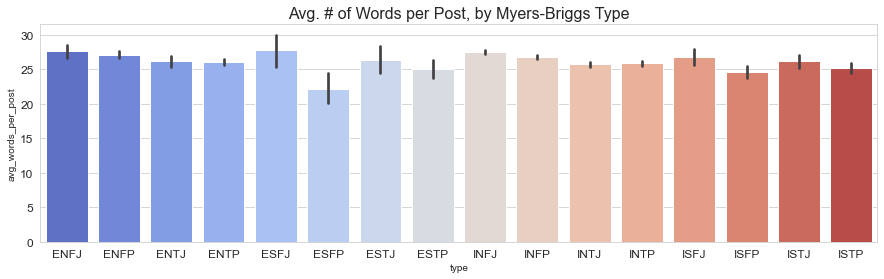

In [9]:
# Bar graph of length of post, by 16 types
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.barplot(x="type", y="avg_words_per_post", data=df, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"]);
plt.title("Avg. # of Words per Post, by Myers-Briggs Type", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [10]:
def polarity(text):
    text = TextBlob(text)
    return text.sentiment.polarity

In [12]:
df['polarity'] = df['clean_posts'].apply(polarity)
df.head()


,type,posts,clean_posts,total_words,avg_words_per_post,polarity
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'URL URL enfp and intj moments URL sportscen...,624,12.48,0.174200
1,ENTP,'I'm finding the lack of me in these posts ver...,'I'm finding the lack of me in these posts ver...,1268,25.36,0.174525
2,INTP,'Good one _____ https://www.youtube.com/wat...,"'Good one _____ URL Of course, to which I s...",913,18.26,0.188119
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","'Dear INTP, I enjoyed our conversation the o...",1164,23.28,0.123478
4,ENTJ,'You're fired.|||That's another silly misconce...,'You're fired. That's another silly misconcept...,1049,20.98,0.068665


In [13]:
df['polarity'].mean()

0.1331329227098038

In [14]:
# Average polarity of posts, by 16 types
df['polarity'].groupby(df['type']).mean()

type
ENFJ    0.171106
ENFP    0.161090
ENTJ    0.131794
ENTP    0.128875
ESFJ    0.156516
ESFP    0.133279
ESTJ    0.132034
ESTP    0.131005
INFJ    0.140826
INFP    0.136957
INTJ    0.119186
INTP    0.112073
ISFJ    0.149495
ISFP    0.152779
ISTJ    0.125746
ISTP    0.115987
Name: polarity, dtype: float64

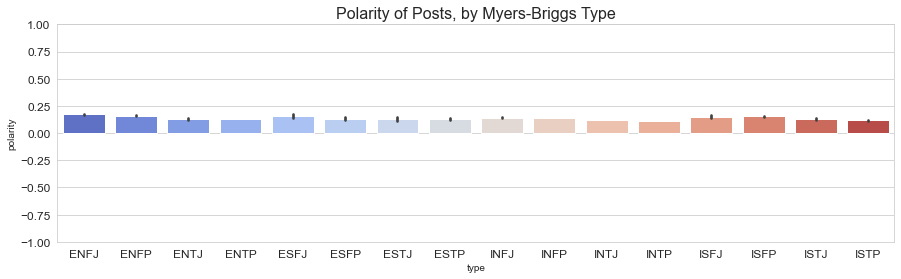

In [15]:
# Bar graph of polarity, by 16 types
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.barplot(x="type", y="polarity", data=df, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"])
plt.title("Polarity of Posts, by Myers-Briggs Type", fontsize=16)
plt.ylim(-1, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [16]:
def subjectivity(text):
    text = TextBlob(text)
    return text.sentiment.subjectivity

In [17]:
df['subjectivity'] = df['clean_posts'].apply(subjectivity)
df.head()

,type,posts,clean_posts,total_words,avg_words_per_post,polarity,subjectivity
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,'URL URL enfp and intj moments URL sportscen...,624,12.48,0.174200,0.502012
1,ENTP,'I'm finding the lack of me in these posts ver...,'I'm finding the lack of me in these posts ver...,1268,25.36,0.174525,0.551938
2,INTP,'Good one _____ https://www.youtube.com/wat...,"'Good one _____ URL Of course, to which I s...",913,18.26,0.188119,0.615378
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...","'Dear INTP, I enjoyed our conversation the o...",1164,23.28,0.123478,0.546078
4,ENTJ,'You're fired.|||That's another silly misconce...,'You're fired. That's another silly misconcept...,1049,20.98,0.068665,0.513298


In [18]:
# Average subjectivity of posts, overall
df['subjectivity'].mean()

0.5401621653498002

In [19]:
df['subjectivity'].groupby(df['type']).mean()

type
ENFJ    0.556873
ENFP    0.559246
ENTJ    0.534690
ENTP    0.540593
ESFJ    0.547430
ESFP    0.551374
ESTJ    0.536098
ESTP    0.540242
INFJ    0.541934
INFP    0.546770
INTJ    0.529273
INTP    0.528651
ISFJ    0.550440
ISFP    0.548526
ISTJ    0.524557
ISTP    0.527188
Name: subjectivity, dtype: float64

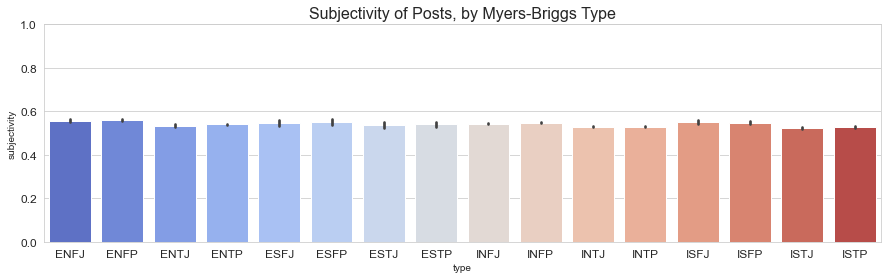

In [20]:
# Bar graph of subjectivity, by 16 types
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.barplot(x="type", y="subjectivity", data=df, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"])
plt.title("Subjectivity of Posts, by Myers-Briggs Type", fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);